In [ ]:
import casadi as ca
import numpy as np

def integrator(f: ca.Function, x: ca.SX, u: ca.SX, dt: ca.SX):
    k1 = f(x, u)
    k2 = f(x + 0.5 * dt * k1, u)
    k3 = f(x + 0.5 * dt * k2, u)
    k4 = f(x + dt * k3, u)
    return x + (dt/ 6.0) * (k1 + 2.0 * k2 + 2.0 * k3 + k4)


# symbolic dynamics model for estimation and control
q_BI = ca.SX.sym('q_BI', 4)
omega = ca.SX.sym('omega', 3)
omega_w = ca.SX.sym("omega_w", 3)
x = ca.vertcat(q_BI, omega, omega_w)
u = ca.SX.sym('inputs', 6)
u_rw = u[:3]
u_mag = u[3:]

J_B = np.eye(3,3)
J_w = np.ones(1)
A_hat = np.eye(3,3)
dt = 0.01

                    
qx, qy, qz, qw = q_BI[0], q_BI[1], q_BI[2], q_BI[3]
wx, wy, wz = omega[0], omega[1], omega[2]
q_dot = 0.5 * ca.vertcat(
    -qx*wx - qy*wy - qz*wz,
    qw*wx + qy*wz - qz*wy,
    qw*wy - qx*wz + qz*wx,
    qw*wz + qx*wy - qy*wx
)

h_int = A_hat @ (J_w * (omega_w + A_hat @ omega)) 
tau_rw = A_hat @ u_rw # electrical dynamics not included
tau_mag = u_mag # TODO: implement

cross_term = ca.cross(omega, J_B @ omega + h_int)
total_torque = tau_mag - tau_rw - cross_term
omega_dot = ca.solve(J_B, total_torque)
omega_w_dot = u_rw / J_w - A_hat @ omega_dot

dx = ca.vertcat(q_dot, omega_dot, omega_w_dot)

f = ca.Function("system_dynamics", [x, u], [dx])

x_next = integrator(f, x, u, dt)

F = ca.Function("F", [x, u, dt], [x_next], ['x','u','dt'], ['x_next'])

In [ ]:
from filterpy.kalman import ExtendedKalmanFilter
import casadi as ca

# TODO: implement extended kalman filter wrapper
class IMUEKF(ExtendedKalmanFilter):
    def __init__(self, dim_x, dim_z, f: ca.Function, g: ca.Function):
        super().__init__(dim_x, dim_z)

        self.f = f # process model

        dt = ca.SX.sym("dt")
        self.F = integrator(self.f, self.x, u, dt) # function returns next state
        
        self.g = g # measurement model

        self.g_jac = g.jacobian()

    def predict_x(self, u, dt):
        self.x = self.F(self.x, u, dt)

    def update(self, z):

        super().update(z, self.g_jac, self.g)


In [ ]:
import json

eos_path = r"tudsat-trace_eos.json"


with open(eos_path, "r") as f:
    eos_file = json.load(f)

eos_file["ModelObjects"]["Reaction Wheel1"]["Orientation"]

'{{M11:1.00000000, M12:0.00000000, M13:0.00000000}, {M21:0.00000000, M22:0.00000000, M23:-1.00000000}, {M31:0.00000000, M32:1.00000000, M33:0.00000000}}'

In [9]:
import numpy as np
import re

# The input string representing a matrix
A = '{{M11:1.00000000, M12:0.00000000, M13:0.00000000}, {M21:0.00000000, M22:0.00000000, M23:-1.00000000}, {M31:0.00000000, M32:1.00000000, M33:0.00000000}}'

# This regular expression finds sequences that look like floating-point numbers.
# It matches an optional negative sign, followed by digits, a decimal point, and more digits.
pattern = r'-?\d+\.\d+'

# Use re.findall() to extract all numbers from the string
numbers_as_strings = re.findall(pattern, A)

# Convert the list of strings to a NumPy array of floating-point numbers
# and reshape it into a 3x3 matrix.
numpy_array = np.array(numbers_as_strings, dtype=float).reshape((3, 3))

# Print the resulting NumPy array
print(numpy_array)


[[ 1.  0.  0.]
 [ 0.  0. -1.]
 [ 0.  1.  0.]]


In [5]:
from satellite import Spacecraft, Surface, replace_orientation_matrices
import json

eos_path = r"tudsat-trace_eos.json"


with open(eos_path, "r") as f:
    eos_file = json.load(f)

data = replace_orientation_matrices(eos_file)       
# data["ModelObjects"]["Solar Panel +X"]["Orientation"][2, 0] = -1
# data["ModelObjects"]["Solar Panel +X"]["Orientation"][0, 2] = 1
surfaces = [Surface.from_eos_panel(v) for k, v in data["ModelObjects"].items() if "panel" in k.lower()]
# rws
# magnetorquers
# sun_sensor
# magnetometer
# gps
# accelerometer
# gyro
# rw_speed_sensors

# Spacecraft(m, J_B, surfaces, rws, magnetorquers, sun_sensor, magnetometer, gps, accelerometer, gyro, rw_speed_sensors)
surfaces

In [ ]:
data["ModelObjects"]["Solar Panel +X"]["Orientation"][:, 2]

array([1., 0., 0.])

[-0.05  0.    0.07]
[-1.  0.  0.]
0.010000000000000002


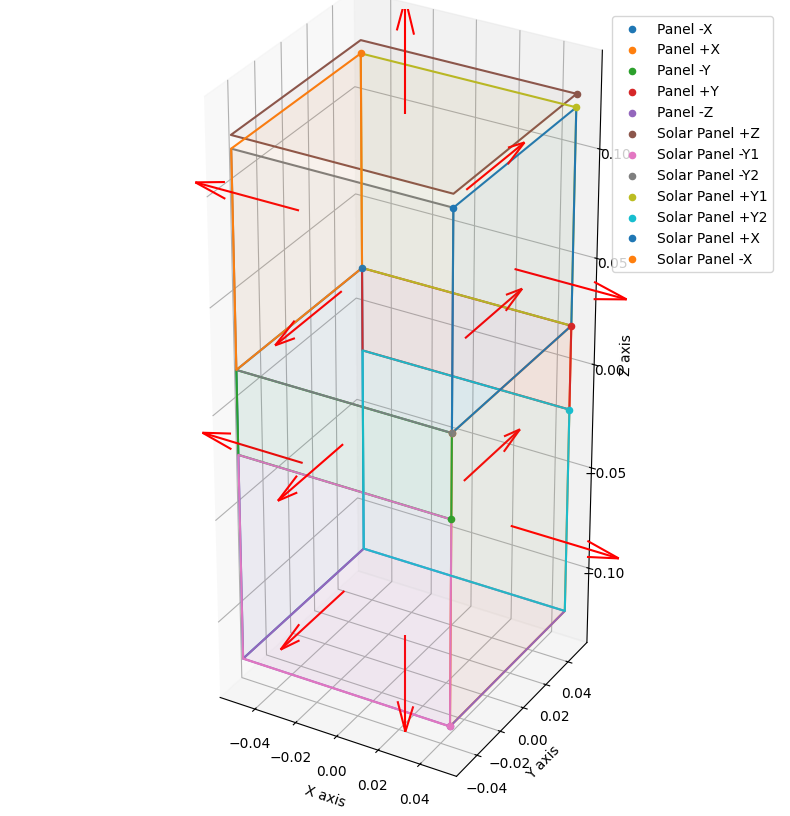

In [9]:
from itertools import cycle
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from matplotlib.colors import TABLEAU_COLORS


"""
"Panel -X": {
      "$type": "Eos.Models.Satellite.CubeSatLibrary.CoverPanel, CubeSatLibrary",
      "DimX": 0.14,
      "DimY": 0.1,
      "NumSurfModelSegsX": 1,
      "NumSurfModelSegsY": 1,
      "HasHole": false,
      "HoleX": 0.0,
      "HoleY": 0.0,
      "HoleRadius": 0.0,
      "Position": "{X:-0.05, Y:0.05, Z:0.02}",
      "Orientation": "{
                    {M11:0.00000000, M12:0.00000000, M13:-1.00000000}, 
                    {M21:0.00000000, M22:-1.00000000, M23:0.00000000}, 
                    {M31:-1.00000000, M32:0.00000000, M33:0.00000000}}"
    }
"""

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

s = surfaces[0]

# solar panel = 10x10cm 
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = cycle(prop_cycle.by_key()['color'])

names = [k for k, v in data["ModelObjects"].items() if "panel" in k.lower()] 
for i, s in enumerate(surfaces):
    c = next(colors)
    s.plot(ax, c, 0.05, 0.05)
    ax.scatter(*s.pos, c=c, label=names[i])
#surfaces[1].plot(ax)
ax.set_ylabel("Y axis")
ax.set_xlabel("X axis")
ax.set_zlabel("Z axis")
print(s.center)
print(s.normal)
print(s.area)
# ax.set_xlim(-2, 2)
# ax.set_ylim(-2, 2)
# ax.set_zlim(-2, 2)
ax.set_aspect("equal")
ax.legend()
fig.tight_layout()

In [8]:
for s in surfaces:
    print(s.center)

[-0.05  0.05  0.02]
[ 0.05 -0.05  0.02]
[ 0.05 -0.05 -0.02]
[0.05 0.05 0.02]
[ 0.05 -0.05 -0.12]
